# Wells Fargo take-home project
## Quantitative Analytical Specialist 2/3/4

### Bibliography / references
1. https://scikit-learn.org/stable/about.html#citing-scikit-learn
1. https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
1. https://datascienceplus.com/multi-class-text-classification-with-scikit-learn/
1. https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/
1. https://www.digitalvidya.com/blog/document-classification-python-machine-learning/
1. https://stackoverflow.com/questions/33091376/python-what-is-exactly-sklearn-pipeline-pipeline/33094099#33094099

In [1]:
import sys
import logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

def add_path(newPath:str) -> str:
    """
    Adds newPath to the existing sys path, if needed.
    :param newPath: gets added temporarily to the PYTHONPATH.
    :return: updated string
    """
    if newPath in sys.path:
        logger.warning(f'path: {newPath} is already on sys.path. (No action taken.)')
        return sys.path
    else:
        logger.debug(f'Adding new path: {newPath} to sys.path.')
        sys.path.append(newPath)
    return sys.path

add_path(r'C:\Users\Owner\PycharmProjects\Utilities')

DEBUG:__main__:Adding new path: C:\Users\Owner\PycharmProjects\Utilities to sys.path.


['C:\\Users\\Owner\\PycharmProjects\\DataScience',
 'C:\\Users\\Owner\\Anaconda3\\python37.zip',
 'C:\\Users\\Owner\\Anaconda3\\DLLs',
 'C:\\Users\\Owner\\Anaconda3\\lib',
 'C:\\Users\\Owner\\Anaconda3',
 '',
 'C:\\Users\\Owner\\AppData\\Roaming\\Python\\Python37\\site-packages',
 'C:\\Users\\Owner\\Anaconda3\\lib\\site-packages',
 'C:\\Users\\Owner\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\Owner\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\Owner\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\Owner\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Owner\\.ipython',
 'C:\\Users\\Owner\\PycharmProjects\\Utilities']

# Read in a prep data

In [14]:
from PandasUtil import PandasUtil
pu = PandasUtil()
df = pu.read_df_from_csv(csv_file_name="complaints-2020-02-15_20_25.csv", header=0)
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,04/01/19,Checking or savings account,Checking account,Managing an account,Banking errors,Wells Fargo has sent me several general form l...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CT,06320,None,Consent provided,Web,04/01/19,Closed with monetary relief,Yes,NaN,3197548
1,04/10/19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,This in reference to Wells Fargo bank. Referen...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,NH,None,None,Consent provided,Web,04/10/19,Closed with explanation,Yes,NaN,3207262
2,04/03/19,Checking or savings account,Savings account,Managing an account,Deposits and withdrawals,I went into the Wells Fargo branch inside the ...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,934XX,Servicemember,Consent provided,Web,04/03/19,Closed with non-monetary relief,Yes,NaN,3200916
3,05/29/19,Checking or savings account,Checking account,Opening an account,Account opened as a result of fraud,I have been notified by XXXX XXXX XXXX that I...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,TX,760XX,Servicemember,Consent provided,Web,05/29/19,Closed with explanation,Yes,NaN,3257338
4,03/31/19,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,"On XX/XX/XXXX & XXXX, my identity was stolen. ...",Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,MO,631XX,None,Consent provided,Web,03/31/19,Closed with explanation,Yes,NaN,3196955


## Drop headers (except for Product and Consumer complaint narrative)

In [15]:
_PRODUCT = 'Product'
_COMPLAINT = 'Complaint'

pu.replace_col_names(df=df, replace_dict = {'Consumer complaint narrative': _COMPLAINT}, is_in_place=True)
pu.drop_col_keeping(df, cols_to_keep=[_PRODUCT, _COMPLAINT], is_in_place=True)
df.head()

,Product,Complaint
0,Checking or savings account,Wells Fargo has sent me several general form l...
1,"Credit reporting, credit repair services, or o...",This in reference to Wells Fargo bank. Referen...
2,Checking or savings account,I went into the Wells Fargo branch inside the ...
3,Checking or savings account,I have been notified by XXXX XXXX XXXX that I...
4,"Credit reporting, credit repair services, or o...","On XX/XX/XXXX & XXXX, my identity was stolen. ..."


## Count how many products we have

In [16]:
issues_df = pu.count_by_column(df, _PRODUCT)
issues_df.head(20)

Mortgage                                                                        6287
Checking or savings account                                                     2265
Bank account or service                                                         1927
Credit reporting, credit repair services, or other personal consumer reports    1167
Credit card or prepaid card                                                     1121
Debt collection                                                                  791
Credit card                                                                      710
Consumer Loan                                                                    536
Student loan                                                                     486
Money transfer, virtual currency, or money service                               455
Vehicle loan or lease                                                            403
Payday loan, title loan, or personal loan                        

### Consolidate the smallest products with fewer than 200
1. Payday loan, title loan, or personal loan >> Consumer loan
1. Money transfers >> Money transfer, virtual currency, or money service
1. Credit reporting >> Credit reporting, credit repair services, or other personal consumer report
1. Prepaid card >> Credit card or prepaid card 
1. Payday loan >> Consumer loan
1. Other financial service >> (drop)

In [17]:
# Build the a replacement dictionary with all values the same.
products = list(issues_df.to_dict().keys())
replace_dict = dict(zip(products, products)) # {'Mortgage': 'Mortgage', 'Checking or savings account': 'Checking or savings account',... }


In [18]:
replace_dict['Payday loan, title loan, or personal loan'] = 'Consumer Loan'
replace_dict['Money transfers'] = 'Money transfer, virtual currency, or money service'
replace_dict['Credit reporting'] = 'Credit reporting, credit repair services, or other personal consumer reports'
replace_dict['Prepaid card'] = 'Credit card or prepaid card' 
replace_dict['Payday loan'] = 'Consumer Loan'

df = pu.replace_col(df, column=_PRODUCT, replace_dict=replace_dict)
pu.get_rowCount_colCount(df)
df = pu.drop_row_by_criterion(df, _PRODUCT, 'Other financial service', False)
pu.get_rowCount_colCount(df)
df.head()

DEBUG:PandasUtil:df has 16424 rows and 2 columns.
DEBUG:PandasUtil:df has 16419 rows and 2 columns.


,Product,Complaint
0,Checking or savings account,Wells Fargo has sent me several general form l...
1,"Credit reporting, credit repair services, or o...",This in reference to Wells Fargo bank. Referen...
2,Checking or savings account,I went into the Wells Fargo branch inside the ...
3,Checking or savings account,I have been notified by XXXX XXXX XXXX that I...
4,"Credit reporting, credit repair services, or o...","On XX/XX/XXXX & XXXX, my identity was stolen. ..."


In [19]:
issues_df = pu.count_by_column(df, _PRODUCT)
issues_df.head(20)

Mortgage                                                                        6287
Checking or savings account                                                     2265
Bank account or service                                                         1927
Credit reporting, credit repair services, or other personal consumer reports    1196
Credit card or prepaid card                                                     1134
Debt collection                                                                  791
Credit card                                                                      710
Consumer Loan                                                                    699
Money transfer, virtual currency, or money service                               521
Student loan                                                                     486
Vehicle loan or lease                                                            403
Name: Product, dtype: int64

In [20]:
# Drop null rows
df = pu.without_null_rows(df, _PRODUCT)
pu.get_rowCount_colCount(df)
df = pu.without_null_rows(df, _COMPLAINT)
pu.get_rowCount_colCount(df)


DEBUG:PandasUtil:df has 16419 rows and 2 columns.
DEBUG:PandasUtil:df has 16419 rows and 2 columns.


(16419, 2)

## Should we oversample the categories with few results?
Might consider oversampling. However, it would be nice to have the big category (Mortgage) to carry more weight. 

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Users\\Owner\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


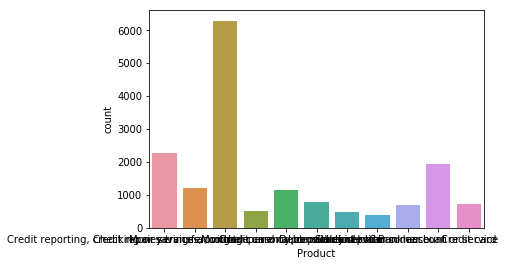

In [21]:
## Plot the frequencies of the different plots.
from PlotUtil import PlotUtil
plu = PlotUtil()
plu.count_plot(df, xlabel = _PRODUCT, return_function_do_not_plot = False)

## Should we drop duplicates?

In [22]:
dups = pu.duplicate_rows(df, [_COMPLAINT] )
logger.debug(f'Found {len(dups)} duplicates.')
dups.head(20)

DEBUG:__main__:Found 56 duplicates.


,Product,Complaint
291,Debt collection,This kind of account is placed as a charged of...
303,Debt collection,This kind of account is placed as a charged of...
3416,"Credit reporting, credit repair services, or o...",I just received the most disappointing respons...
3433,"Credit reporting, credit repair services, or o...",Wells Fargo refuses to own up and face their r...
3484,Debt collection,This kind of account is placed as a charged of...
3510,Credit card or prepaid card,This kind of account is placed as a charged of...
3538,"Credit reporting, credit repair services, or o...","Wells Fargo Mortgage ; Loans XXXX, and XXXX We..."
3960,Mortgage,This particular account situation that is late...
4935,Mortgage,FHA CASE # XXXX A modification was approved on...
6182,Debt collection,Creditor is reporting accounts that are invali...


In [23]:
# Yes, let's drop.
df = pu.drop_duplicates(df, [_COMPLAINT] )
pu.get_rowCount_colCount(df)

DEBUG:PandasUtil:df has 16363 rows and 2 columns.


(16363, 2)

## Create a category ID corresponding to Product

In [24]:
from io import StringIO
_ID = 'category_id'
df[_ID] = df[_PRODUCT].factorize()[0]
category_id_df = df[[_PRODUCT, _ID]].drop_duplicates().sort_values(_ID)
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[[_ID, _PRODUCT]].values)
df.head()

,Product,Complaint,category_id
0,Checking or savings account,Wells Fargo has sent me several general form l...,0
1,"Credit reporting, credit repair services, or o...",This in reference to Wells Fargo bank. Referen...,1
2,Checking or savings account,I went into the Wells Fargo branch inside the ...,0
3,Checking or savings account,I have been notified by XXXX XXXX XXXX that I...,0
4,"Credit reporting, credit repair services, or o...","On XX/XX/XXXX & XXXX, my identity was stolen. ...",1


## Do the train / test split


In [25]:
from DataScienceUtil import DataScienceUtil
dsu = DataScienceUtil()
X_train, X_test, y_train, y_test = dsu.train_test_split(X=df[_COMPLAINT], y=df[_ID], test_frac=0.2, seed=42)
logger.info(f'X_train is shape {X_train.shape}. y_test is {y_test.shape}.')

DEBUG:LogitUtil:Entering init_logger.
DEBUG:LogitUtil:Exiting init_logger.
2020-02-20 08:12:25,739 INFO Starting
2020-02-20 08:12:25,739 INFO Starting
INFO:Util:Starting
INFO:__main__:X_train is shape (13090,). y_test is (3273,).


# Linear Regression model
## First, tf-idf
### sublinear_tf is set to True to use a logarithmic form for frequency
### min_df = 5 means the word must be present in 5 documents
### ngram_range includes unigrams and bigrams.
### stop_words are English
X_train has 13090 rows and 46953 features.

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vX = vect.fit_transform(X_train)
print (vX)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
logger.debug(f'Type of df["Complaint"] is {type(df[_COMPLAINT])}. ')
logger.debug(f'Type of X_train is {type(X_train)}. ')

features = tfidf.fit_transform(df[_COMPLAINT]).toarray()



logger.debug(f'Type of features is {type(features)}. ')
labels = df[_ID]
features.shape

DEBUG:__main__:Type of df["Complaint"] is <class 'pandas.core.series.Series'>. 
DEBUG:__main__:Type of X_train is <class 'pandas.core.series.Series'>. 
DEBUG:__main__:Type of features is <class 'numpy.ndarray'>. 


(16363, 57851)

In [ ]:
# Takes an inordiante time to run this cell. 
from sklearn.feature_selection import chi2
import numpy as np

top_grams = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-top_grams:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-top_grams:])))


# 'Bank account or service':
  . Most correlated unigrams:
       . deposit
       . checking
       . overdraft
  . Most correlated bigrams:
       . 35 00
       . checking account
       . overdraft fees
# 'Checking or savings account':
  . Most correlated unigrams:
       . checking
       . deposit
       . bonus
  . Most correlated bigrams:
       . overdraft fees
       . debit card
       . checking account
# 'Consumer Loan':
  . Most correlated unigrams:
       . car
       . vehicle
       . dealer
  . Most correlated bigrams:
       . auto loan
       . fargo dealer
       . dealer services
# 'Credit card':
  . Most correlated unigrams:
       . dillard
       . dillards
       . card
  . Most correlated bigrams:
       . balance transfer
       . card wells
       . credit card


## Some caveats from the chi-squared results
1. This took an inordinate amount of time 
## Conclusions from the chi-squared results of feature extraction
1. Some bigrams, like "35 00," make no sense. Perhaps substitute numbers with #NUM
## Future exploration
1. See if trigrams would improve the chi-squared.

## Continuing the TF-IDF, using a pipeline
### First, generate the Count Vectorizer
Using the NLTK stop word list at https://gist.github.com/sebleier/554280 because of known problems with using 'english' in scikit-learn. 

In [14]:
# Based on https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
from sklearn.feature_extraction.text import CountVectorizer
my_stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 
'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 
'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 
'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 
'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 
'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 
'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
'should', 'now',] # from NLTK's list 
count_vect = CountVectorizer(ngram_range=(2, 2), stop_words=my_stop_words)
X_train_counts = count_vect.fit_transform(X_train)
logger.debug(f'Shape of X_train counts is: {X_train_counts.shape}')

DEBUG:__main__:Shape of X_train counts is: (13090, 631903)


### After the count vectorizer, may retrieve the frequency of a given word

In [15]:
def word_freq(count_vec, find_me: str): 
    logger.debug(f'The count of {find_me} is: {count_vec.vocabulary_.get(find_me)}')
    
logger.debug(f'some of vocabulary is {list(count_vect.vocabulary_)[:20]}')
word_freq(count_vect, list(count_vect.vocabulary_)[0])


DEBUG:__main__:some of vocabulary is ['trying modify', 'modify home', 'home loan', 'loan five', 'five months', 'months keep', 'keep getting', 'getting run', 'run around', 'around every', 'every time', 'time ask', 'ask representative', 'representative fact', 'fact items', 'items requested', 'requested states', 'states everything', 'everything inn', 'inn turn']
DEBUG:__main__:The count of trying modify is: 577229


### Now set up the TF-IDF transformer

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(13090, 631903)

## Train the classifier

In [17]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_tfidf, y_train)
docs_new = ['I am trying to modify my home loan.', 'Please refund the fees on my checking account.', 'Renegotiate my student loan']
X_new_counts = count_vect.transform(docs_new)
print (X_new_counts)

X_new_tfidf = tfidf_transformer.transform(X_new_counts)

def look_up_category(find_me:int) -> str:
    for cat, cat_id in category_to_id.items():
        if find_me == cat_id:
            return cat
    return "<not found!>"

predicted = clf.predict(X_new_tfidf)
logger.debug(f'predicted vector is: {predicted}')
for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, look_up_category(category)))

DEBUG:__main__:predicted vector is: [2 2 2]


  (0, 270664)	1
  (0, 356017)	1
  (0, 577229)	1
  (1, 109822)	1
  (1, 225200)	1
  (1, 418901)	1
  (1, 462097)	1
  (2, 540502)	1
'I am trying to modify my home loan.' => Mortgage
'Please refund the fees on my checking account.' => Mortgage
'Renegotiate my student loan' => Mortgage


## Continuing with a pipeline
### This will simplify the other models

In [35]:
from sklearn.pipeline import Pipeline

import numpy as np

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
logger.debug(f'X_train_tfidf.shape is {X_train_tfidf.shape}')

text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2), min_df=5, vocabulary=count_vect.vocabulary_)._validate_vocabulary()),
#    ('vect', CountVectorizer()._validate_vocabulary()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB().fit(X_train_tfidf, y_train)),
])


DEBUG:__main__:X_train_tfidf.shape is (13090, 631903)


# Naïve Bayes
"The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work." From https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [36]:
# count_vect._validate_vocabulary()
predicted = text_clf.predict(X_test)
print (predicted[-10:])
print (y_test[-10:])
np.mean(predicted == y_test)

ValueError: could not convert string to float: 'The company is requiring a " cushion \'\' in my escrow account, which is causing the payment to be much less affordable. Per RESPA guidelines, the company is allowed to implement a cushion comprised of two months of escrow payments, but they are not required to do so. In order to pay my mortgage without undue strain on my finances, I have respectfully requested Wells Fargo waive the requirement as a courtesy. I was continually lied to on the phone by agents of Wells Fargo, who stated that the cushion was required under the law. I advised them this is incorrect, and that it is an internal business decision to require the cushion. My call was escalated to an escalation team, and after speaking with an agent named XXXX, was advised after no contact for two weeks that they flatly denied my request, providing no other reasoning other beyond " other servicers may have different requirements but Wells Fargo requires the cushion. \'\' I do not dispute that there was an increase in the amount of my escrow obligation, but the requirement of the " cushion \'\' is not federally mandated, and it is fully within the ability of the company to waive the cushion in order to better accommodate the needs of one of their customers. I have been nothing but respectful in my interactions with the company, and yet now they leave me out to dry. I need assistance so that I can continue to pay my mortgage. I am a first time homebuyer, but have years of experience in the mortgage industry, and it is shameful the way that Wells Fargo treats their customers, especially in light of their XXXX XXXX dollar settlement due to unfair practices. You\'d think they would like to help their customers in order to raise their respectability in the public eye, but it turns out that is not the case.'

# Naïve Bayes train function
Defining a train function that will take a pipeline.

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

def train(pipeline: Pipeline, title:str) -> Pipeline:
    X_train, X_test, y_train, y_test = dsu.train_test_split(X=df[_COMPLAINT], y=df[_ID], test_frac=0.2, seed=42)
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    logger.info(f'Accuracy for {title}: {score*100.0:.3f}%.')
    return pipeline

# Naïve Bayes Trial 0
Simple test, all things out-of-the-box. Using unigrams only.

In [57]:
trial0 = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 1))),
    ('clf', MultinomialNB()),
])
train(trial0, "Trial 0 (Using unigrams.)")

INFO:__main__:Accuracy for Trial 0 (Using unigrams.): 39.505%.


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

# Naïve Bayes Trial 1
Using unigrams and bigrams.

In [58]:
trial1 = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', MultinomialNB()),
])
train(trial1, "Trial 1 (Using unigrams and bigrams.)")

INFO:__main__:Accuracy for Trial 1 (Using unigrams and bigrams.): 37.305%.


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

# Naïve Bayes Trial 2
Simple test, all things out-of-the-box. Using bigrams and trigrams.

In [59]:
trial2 = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(2, 3))),
    ('clf', MultinomialNB()),
])
train(trial2, "Trial 2 (Using bigrams and trigrams.)")

INFO:__main__:Accuracy for Trial 2 (Using bigrams and trigrams.): 37.519%.


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(2, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

# Naïve Bayes Trial 3
## Adding stop words.
Using the NLTK stop word list at https://gist.github.com/sebleier/554280 because of known problems with using 'english' in scikit-learn. 
Will use unigrams only.

In [37]:
my_stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 
'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 
'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 
'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 
'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 
'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 
'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
'should', 'now',] # from NLTK's list
trial3 = Pipeline([
    ('vect', TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1, 1))),
    ('clf', MultinomialNB()),
])
train(trial3, "Trial 3 (with stop words)")

INFO:__main__:Accuracy for Trial 3 (with stop words): 42.010%.


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'her', 'hers',
                                             'herself', 'it', 'its', 'itself',
          

# Support Vector Machine
Using Stochastic Gradient Descent for the classifier. 

In [107]:
from sklearn.linear_model import SGDClassifier
trial4 = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(2, 3))),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])
train(trial4, "Trial 4 (Using SVM and SGD.)")

INFO:__main__:Accuracy for Trial 4 (Using SVM and SGD.): 55.454%.


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(2, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', lo

# Now trying a grid search

In [42]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('vect', TfidfVectorizer(stop_words=my_stop_words)),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          random_state=42,
                          max_iter=5, tol=None)),
])


# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {'vect__ngram_range': [(1, 1), (1, 2), (2, 3)], 
              'vect__max_df': [0.25, 0.50, 0.75, 1.0],
              'clf__alpha': (1e-2, 1e-3),
             }
X_train, X_test, y_train, y_test = dsu.train_test_split(X=df[_COMPLAINT], y=df[_ID], test_frac=0.2, seed=42)

search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)

logger.info("Best parameter (CV score=%0.3f):" % search.best_score_)
logger.info(search.best_params_)


C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  6.4min finished
INFO:__main__:Best parameter (CV score=0.647):
INFO:__main__:{'clf__alpha': 0.001, 'vect__max_df': 0.75, 'vect__ngram_range': (1, 1)}


In [106]:
from sklearn.linear_model import SGDClassifier

pipe_best = Pipeline([
    ('vect', TfidfVectorizer(stop_words=my_stop_words, max_df=0.75, ngram_range=(1,1))),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha= 0.001, random_state=42,
                          max_iter=5, tol=None)),
])
train(pipe_best, "Trial using grid search (Using SVM and SGD, 'clf__alpha': 0.001, 'vect__max_df': 0.75, 'vect__ngram_range': (1, 1).)")

INFO:__main__:Accuracy for Trial using grid search (Using SVM and SGD, 'clf__alpha': 0.001, 'vect__max_df': 0.75, 'vect__ngram_range': (1, 1).): 65.536%.


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
    

# Predictions based on best model

In [113]:
# Create a dataframe with y_test and y_pred
y_df = pu.convert_list_to_dataframe(list(y_test), ["y_test"])
y_df['y_pred'] = y_predict.reshape((-1, 1))
logger.debug(f'y_df starts with:\n{y_df.head()}')
# Now build the confusion matrix
ans = []
size = len(np.unique(y_test))
logger.debug(f'size is: {size}')
for i in range(size):
    row = []
    for j in range(size):
        all_test_i = pu.select(y_df, 'y_test', i)
        all_test_i_pred_j = pu.select(all_test_i, 'y_pred', j)
        logger.debug(f'for test {i} vs pred {j}: {len(all_test_i_pred_j)}')
        row.append(len(all_test_i_pred_j))
    ans.append(row)
logger.debug(f'ans:\n{ans}')

DEBUG:__main__:y_df starts with:
   y_test  y_pred
0       2       2
1       1       1
2       2       2
3       2       2
4       5       2
DEBUG:__main__:size is: 11
DEBUG:__main__:for test 0 vs pred 0: 298
DEBUG:__main__:for test 0 vs pred 1: 3
DEBUG:__main__:for test 0 vs pred 2: 69
DEBUG:__main__:for test 0 vs pred 3: 16
DEBUG:__main__:for test 0 vs pred 4: 10
DEBUG:__main__:for test 0 vs pred 5: 1
DEBUG:__main__:for test 0 vs pred 6: 0
DEBUG:__main__:for test 0 vs pred 7: 0
DEBUG:__main__:for test 0 vs pred 8: 0
DEBUG:__main__:for test 0 vs pred 9: 66
DEBUG:__main__:for test 0 vs pred 10: 1
DEBUG:__main__:for test 1 vs pred 0: 5
DEBUG:__main__:for test 1 vs pred 1: 112
DEBUG:__main__:for test 1 vs pred 2: 73
DEBUG:__main__:for test 1 vs pred 3: 0
DEBUG:__main__:for test 1 vs pred 4: 11
DEBUG:__main__:for test 1 vs pred 5: 4
DEBUG:__main__:for test 1 vs pred 6: 7
DEBUG:__main__:for test 1 vs pred 7: 5
DEBUG:__main__:for test 1 vs pred 8: 4
DEBUG:__main__:for test 1 vs pred 9: 7
DE

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.MaxNLocator object at 0x0000021746E6A940>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.MaxNLocator object at 0x0000021746E6A940>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


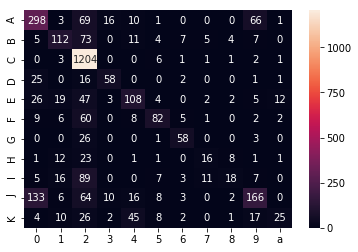

In [105]:
plu.confusion_matrix_plot(ans)